# Trimming the boundaries of categorization for EP permits by hand
Of course we can apply all sorts of 'quantiles' classification but the 'psychological' categorization by humans applying for the permit and issuing it is more important, because humans 'intuitively' categorize certain types of jobs in a certain price range, which makes the probability of finding _your_ particular kind in just one of these 'psychological bins'.

In [8]:
import sqlalchemy as sqlalc
import pandas as pd
import sorting
import matplotlib.pyplot as plt
import numpy

We take a table 'PERMIT - EASY PERMIT PROCESS' from the firstbase.sqlite and will be storing the results in secondbase.sqlite

In [9]:
conn_source = sqlalc.create_engine(sorting.TARGET_DATABASE_URI)
conn_target = sqlalc.create_engine(sorting.INTERM_DATABASE_URI)
    
permits = pd.read_sql_table(table_name='PERMIT - EASY PERMIT PROCESS', con=conn_source)

Verify what we've ingested

In [10]:
permits.head(n=2)

,id,permit_,permit_type,review_type,application_start_date,issue_date,processing_time,street_number,street_direction,street_name,...,contact_13_type,contact_13_name,contact_13_city,contact_13_state,contact_13_zipcode,contact_14_type,contact_14_name,contact_14_city,contact_14_state,contact_14_zipcode
0,2999424,100798057,PERMIT - EASY PERMIT PROCESS,EASY PERMIT,2018-12-19,2019-01-02,14.0,1300,N,LAKE SHORE,...,None,None,None,None,None,None,None,None,None,None
1,3000020,100798403,PERMIT - EASY PERMIT PROCESS,EASY PERMIT,2019-01-02,2019-01-02,0.0,3300,N,LAKE SHORE,...,None,None,None,None,None,None,None,None,None,None


The task is: to figure out the costs/numbers of the boundaries between 'very small' (marked as 'XS'), 'small' (marked as 'S'),  'medium' permits (marked 'M'), 'large' permits (marked 'L'), 'extra large' (marked 'XL') and 'very large' (marked as 'XXL') and 'super large' - 'XXXL'; all in all - 7 sizes. The simplest way to do it is by plotting and changing the parameters.

One column will be enough for this analysis.

In [11]:
reported_costs = permits.loc[:, ['reported_cost']]
mper = {'reported_cost': 'permits'}
reported_costs = reported_costs.rename(mapper=mper, axis='columns')
reported_costs.count(axis='index')

permits    14424
dtype: int64

The 'birds eye view' of the whole thing (in loglog format) is":

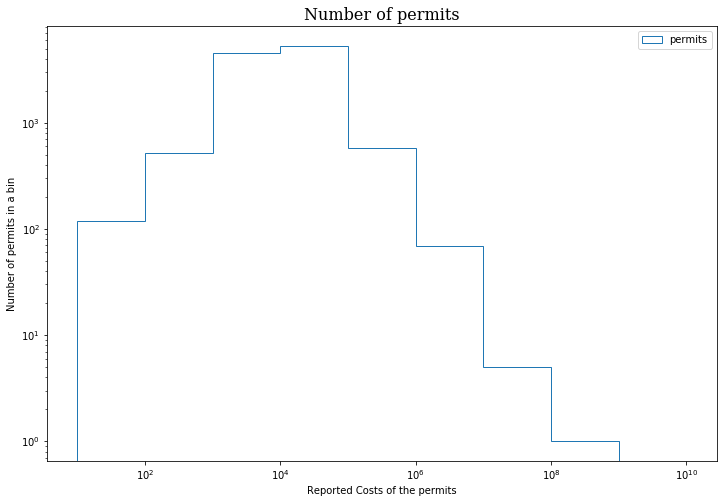

In [12]:
    font_d = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 16}
    bins = numpy.logspace(start=1, stop=10, num=10, endpoint=True)
    Fig_1 = reported_costs.plot(bins=bins, kind='hist', histtype='step', loglog=True, figsize=(12,8))
    Fig_1.set_title("Number of permits", fontdict=font_d)
    Fig_1.set_xlabel('Reported Costs of the permits')
    Fig_1.set_ylabel('Number of permits in a bin')
    plt.show()

It looks like some XXL permits are in this 'type' too! 'Easy permits', for sure!

Another way to look at the segmentation are 'quantiles' of course.

In [36]:
sizes = ['XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', 'XXXL']
pd.qcut(reported_costs['permits'], q=8, duplicates='drop')

0                  (0.999, 450.0]
1        (33693.125, 114506065.0]
2               (6600.0, 11388.0]
3            (17782.0, 33693.125]
4                  (0.999, 450.0]
                   ...           
14419    (33693.125, 114506065.0]
14420          (11388.0, 17782.0]
14421           (6600.0, 11388.0]
14422          (11388.0, 17782.0]
14423             (450.0, 3000.0]
Name: permits, Length: 14424, dtype: category
Categories (7, interval[float64]): [(0.999, 450.0] < (450.0, 3000.0] < (3000.0, 6600.0] < (6600.0, 11388.0] < (11388.0, 17782.0] < (17782.0, 33693.125] < (33693.125, 114506065.0]]

In [13]:
S_M = reported_costs[reported_costs['permits'] < 50000]
S_M.count()

permits    13143
dtype: int64

In [14]:
# prepare to plot
font_d = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}

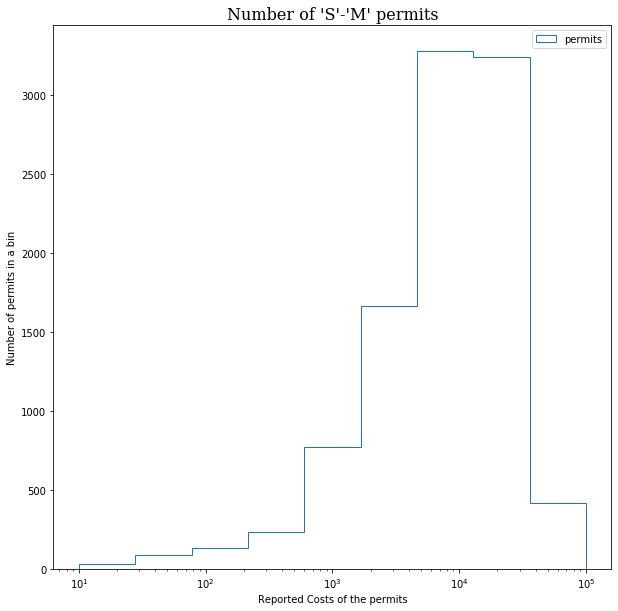

In [18]:
bins = numpy.logspace(start=1, stop=numpy.log10(100000), num=10, endpoint=True)
Fig_1 = S_M.plot.hist(bins=bins, histtype='step', figsize=(10, 10))
Fig_1.set_title("Number of 'S'-'M' permits", fontdict=font_d)
Fig_1.set_xlabel('Reported Costs of the permits')
Fig_1.set_xscale('log')
Fig_1.set_ylabel('Number of permits in a bin')
plt.show()

In [9]:
L = reported_costs[(reported_costs['permits'] >= 50000) & (reported_costs['permits'] < 500000)]
L.count()

permits    1114
dtype: int64

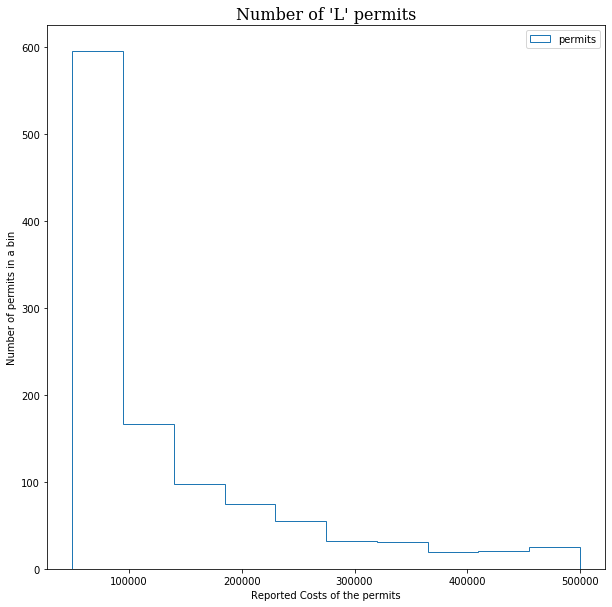

In [10]:
Fig_2 = L.plot.hist(bins=10, histtype='step', figsize=(10, 10))
Fig_2.set_title("Number of 'L' permits", fontdict=font_d)
Fig_2.set_xlabel('Reported Costs of the permits')
Fig_2.set_ylabel('Number of permits in a bin')
plt.show()

In [11]:
XL_without_XXL = reported_costs[(reported_costs['permits'] >= 500000) & (reported_costs['permits'] < 5000000)]
XL_without_XXL.count()

permits    161
dtype: int64

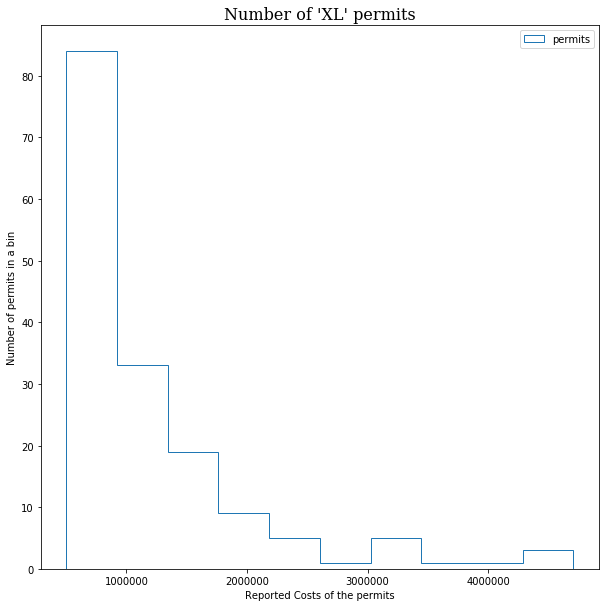

In [12]:
Fig_3 = XL_without_XXL.plot.hist(bins=10, histtype='step', figsize=(10, 10))
Fig_3.set_title("Number of 'XL' permits", fontdict=font_d)
Fig_3.set_xlabel('Reported Costs of the permits')
Fig_3.set_ylabel('Number of permits in a bin')
plt.show()

In [13]:
XXL = reported_costs[(reported_costs['permits'] >= 5000000) & (reported_costs['permits'] < 500000000)]
XXL.count()

permits    6
dtype: int64

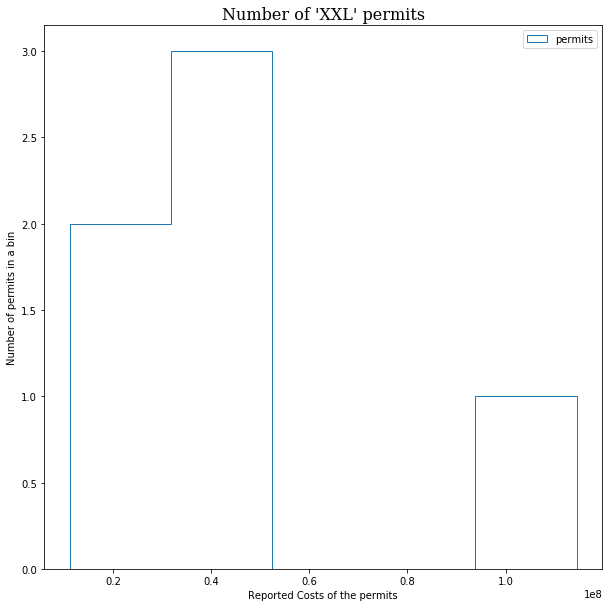

In [14]:
Fig_4 = XXL.plot.hist(bins=5, histtype='step', figsize=(10, 10))
Fig_4.set_title("Number of 'XXL' permits", fontdict=font_d)
Fig_4.set_xlabel('Reported Costs of the permits')
Fig_4.set_ylabel('Number of permits in a bin')
plt.show()

These are, obviously, very rare events (in this category) already.

In [15]:
print('Fin.')

Fin.
